In [22]:
import matplotlib.pyplot as plt
%matplotlib inline  
from numpy import array, sin, cos, pi
from random import random
import tensorflow as tf
import pandas as pd
import csv
import numpy as np
import sys, os
from sklearn.metrics import mean_squared_error, mean_absolute_error

_working_dir = "log"
sys.path.append(_working_dir)

In [23]:
EPOCH = 8

In [24]:
# Read in the pre-trained embeddings. Delimiter by space, without any quote
ujt = pd.read_csv("UJT.csv", header=None, delimiter=',', low_memory=False, dtype=np.float64, skiprows=1)

# Convert data frame into a dict
ujt = ujt.set_index(0).T.to_dict('list')


In [25]:
road_links = [
2334,
2240,
2237,
2236,
2185,
2184,
2183,
1872,
1870,
1771,
1770,
1506,
1214,
1058,
883,
882,
881
]

requiredUJT = []

for i in road_links:
    requiredUJT.append(ujt[i]) 

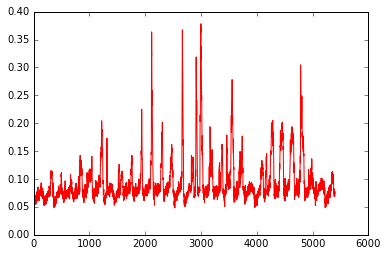

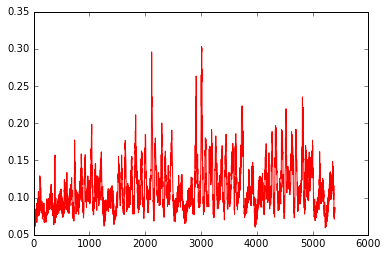

In [26]:
plt.plot(range(len(requiredUJT[0])), requiredUJT[0], 'r-')
plt.show()

plt.plot(range(len(requiredUJT[0])), requiredUJT[1], 'r-')
plt.show()

In [27]:
no_of_historical = 2
no_of_record_per_day = 180
isAddDayofWeek = False
isAddTimeofDay = False
useDerivative = True

print("useDerivative: ", useDerivative)

dimensions_per_record = no_of_historical

if isAddDayofWeek:
    dimensions_per_record += 1
    
if isAddTimeofDay:
    dimensions_per_record += 1


def prepareRoadData(roadData):
    resultX = []
    resultY = []

    for i in range(no_of_historical, len(roadData)):
        rec = []
        last = 0
        for j in (range(1, no_of_historical+1)):
            if useDerivative:
                if last != 0:
                    rec.append(last - roadData[i - j])
                else:
                    rec.append(roadData[i - j])
                last = roadData[i - j]
            else:
                rec.append(roadData[i - j])
        if isAddDayofWeek:
            rec.append(1)
        if isAddTimeofDay:
            rec.append(i%no_of_record_per_day)
            
        resultX.append(rec)
        resultY.append(roadData[i])
        
        
        
    return np.array(resultX), np.reshape(np.array(resultY), (len(resultY),1))


inputX = None 
outputY = None

for i in requiredUJT:
    if inputX is None:
        inputX, outputY = prepareRoadData(i)
    else:
        x, y = prepareRoadData(i)
        inputX = np.concatenate((inputX, x), axis=1)
        outputY = np.concatenate((outputY, y), axis=1)

trainSet = 4137

trainX = inputX[:trainSet]
trainY = outputY[:trainSet]
testX = inputX[trainSet:]
testY = outputY[trainSet:]


# print (testX[0])
# print (testY[0])

# print (testX[1])
# print (testY[1])

# print (testX[2])
# print (testY[2])

# print ("trainX.shape: ", trainX.shape)
# print ("trainY.shape: ", trainY.shape)
# print ("testX.shape: ", testX.shape)
# print ("testY.shape: ", testY.shape)

useDerivative:  True


This input data is much more nonlinear and periodic than the original example

In [28]:
"""
function to reinitialise graph state in case of repeated jupyter cell runs
"""
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()  
    
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
reset_graph()

#Input Params
input_dim = len(road_links)
h_dim = trainX.shape[1] * 2
cell_type = 3

print("cell_type: ", cell_type)
print("h_dim: ", h_dim)

##The Input Layer as a Placeholder
#Since we will provide data sequentially, the 'batch size'
#is 1.
input_layer = tf.placeholder(tf.float32, [1, input_dim*dimensions_per_record])

##Input for correct output (for training)
correct_output = tf.placeholder(tf.float32, [1, input_dim])

## Drop out rate
keep_p = tf.placeholder(tf.float32) 

##Create outputs
output_W1 = tf.Variable(tf.truncated_normal([h_dim, input_dim])) # [h_dim, len(road_links)]
output_b1 = tf.Variable(tf.zeros([input_dim]))

if cell_type == 1:
    cell = tf.nn.rnn_cell.BasicRNNCell(h_dim)
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_p)
    state = cell.zero_state(1, tf.float32)
    output, state_output = cell(input_layer, state, scope="BasicRNN")
    final_output = tf.matmul(output, output_W1) + output_b1
    final_state = state_output
    
if cell_type == 2:
    cell = tf.nn.rnn_cell.GRUCell(h_dim)
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_p)
    state = cell.zero_state(1, tf.float32)
    output, state_output = cell(input_layer, state, scope="GRUCell")
    final_output = tf.matmul(output, output_W1) + output_b1
    final_state = state_output

if cell_type == 3:
    cell = tf.nn.rnn_cell.BasicLSTMCell(h_dim)
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_p)
    state = cell.zero_state(1, tf.float32)
    output, state_output = cell(input_layer, state, scope="BasicLSTM")  # output [1, h_dim]
    
#     final_output = tf.sigmoid(tf.matmul(output, output_W1) + output_b1)
    final_output = tf.matmul(output, output_W1) + output_b1 # final_output [1, len(road_links)]
#     print (output_W1)
    final_state = state_output
    
if cell_type == 4:
    cell = tf.nn.rnn_cell.BasicLSTMCell(h_dim)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell]*2)
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_p)
    state = cell.zero_state(1, tf.float32)
    output, state_output = cell(input_layer, state, scope="LSTM-Layer")
    final_output = tf.matmul(output, output_W1) + output_b1
    final_state = state_output


cell_type:  3
h_dim:  68


In [30]:
learning_rate = 0.00002
print("learning_rate: ", learning_rate)

##Calculate the Sum-of-Squares Error
error = tf.pow(tf.sub(final_output, correct_output), 2)

##The Optimizer
#Adam works best
train_step = tf.train.AdamOptimizer(learning_rate).minimize(error)
w_hist = tf.histogram_summary('weights', output_W1)
b_hist = tf.histogram_summary('biases', output_b1)
y_hist = tf.histogram_summary('y', final_output)



learning_rate:  2e-05


In [31]:
##Session
sess = tf.Session()
    
#Initialize all Variables
merged = tf.merge_summary([w_hist,b_hist,y_hist])
# tf.train.write_graph(sess.graph_def,_working_dir,'graph.txt')
# writer = tf.train.SummaryWriter(_working_dir,sess.graph_def)
sess.run(tf.initialize_all_variables())
numpy_state = sess.run(state)

mse_train_list = []
mse_test_list = []

##Training
for i in range(301):
    actual_output1 = []
    network_output1 = []
    loss = 0

    for j in range(len(trainX)):
        feed_dict = {
                    state: numpy_state,
                    input_layer: np.reshape(trainX[j],(1,input_dim*dimensions_per_record)),
                    correct_output: np.reshape(trainY[j],(1,input_dim)),
                    keep_p: 0.9
                    }

        _, network_output, merge, e, numpy_state = sess.run([
                                                 train_step,
                                                 final_output,
                                                 merged, 
                                                 error, 
                                                 final_state
                                                 ],
                                                 feed_dict=feed_dict)

        loss = loss + e[0][0]
        network_output1.append(network_output[0])
        actual_output1.append(trainY[j])
    
 
    
    if i%1==0:
        print ("Epoch: ", i)
        print ("  Loss: ", loss)
        y = np.array(actual_output1)
        pred = np.array(network_output1)
        
        sum_mape_train = 0
        for i in range(input_dim):
            mape_train = mean_absolute_percentage_error(y[:,i],pred[:,i])
            sum_mape_train += mape_train  

        mse_train = mean_squared_error(actual_output1, network_output1)
        mae_train = mean_absolute_error(actual_output1, network_output1)
        print("  Train Average Mean Squared Error: ", mse_train)
        print("  Train Average Mean Percentage Absolute Error: ", sum_mape_train/input_dim)
#         print("  Train Average Mean Absolute Error: ", mae_train)
        mse_train_list.append(sum_mape_train/input_dim)

        ### Compute current epoch Test set error rate ###
        test_actual_output = []
        test_network_output = []
        
        
        for j in range(len(testX)):
            feed_dict = {
                    state: numpy_state,
                    input_layer: np.reshape(testX[j],(1,input_dim*dimensions_per_record)),
                    correct_output: np.reshape(testY[j],(1,input_dim)),
                    keep_p: 1.0
                    }
            network_output, numpy_state = sess.run([final_output,final_state],
                                         feed_dict = feed_dict)

            test_actual_output.append(testY[j])
            test_network_output.append(network_output[0])

        y = np.array(test_actual_output)
        pred = np.array(test_network_output)
        
        sum_mape = 0
        for i in range(input_dim):
            mape1 = mean_absolute_percentage_error(y[:,i],pred[:,i])
            sum_mape += mape1            
        
        mse_test = mean_squared_error(test_actual_output,test_network_output)
        mae_test = mean_absolute_error(test_actual_output,test_network_output)
        print("  Test Average Mean Squared Error: ", mse_test)
        print("  Test Average Mean Absolute Percentage Error: ", sum_mape/input_dim)
        mse_test_list.append(sum_mape/input_dim)
#         print("  Test Average Mean Absolute Error: ", mae_test)




Epoch:  0
  Loss:  42.338483545
  Train Average Mean Squared Error:  0.0136319123376
  Train Average Mean Percentage Absolute Error:  93.8392643213
  Test Average Mean Squared Error:  0.00455157072203
  Test Average Mean Absolute Percentage Error:  48.9318780851
Epoch:  1
  Loss:  18.9826323507
  Train Average Mean Squared Error:  0.00456847203562
  Train Average Mean Percentage Absolute Error:  51.5406726037
  Test Average Mean Squared Error:  0.00262599579639
  Test Average Mean Absolute Percentage Error:  38.1032675467
Epoch:  2
  Loss:  12.3516498352
  Train Average Mean Squared Error:  0.00269030511083
  Train Average Mean Percentage Absolute Error:  38.8830961609
  Test Average Mean Squared Error:  0.00166827770201
  Test Average Mean Absolute Percentage Error:  30.4705620214
Epoch:  3
  Loss:  8.92566697256
  Train Average Mean Squared Error:  0.00184968115454
  Train Average Mean Percentage Absolute Error:  31.9830582443
  Test Average Mean Squared Error:  0.00113387789644
  Te

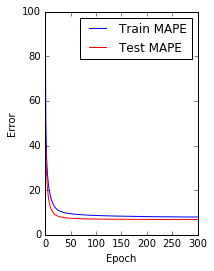

In [32]:
plt.subplot(121)
plt.ylabel('Error')
plt.xlabel('Epoch')        
ta, =plt.plot(mse_train_list,'b',label='Train MAPE')
da, =plt.plot(mse_test_list,'r',label='Test MAPE')     
plt.legend(handles=[ta,da])

  Mean Squared Error for Road 2334 :  8.37809229027e-05
  Mean Absolute Error for Road 2334 :  0.00638298085924
  Mean Absolute Percentage Error for Road 2334 :  7.09793857339
  Mean Squared Error for Road 2240 :  9.67898422246e-05
  Mean Absolute Error for Road 2240 :  0.00703850088399
  Mean Absolute Percentage Error for Road 2240 :  6.39285889357
  Mean Squared Error for Road 2237 :  9.82232984993e-05
  Mean Absolute Error for Road 2237 :  0.0070045010034
  Mean Absolute Percentage Error for Road 2237 :  6.8035854203
  Mean Squared Error for Road 2236 :  6.70830044825e-05
  Mean Absolute Error for Road 2236 :  0.00552295983254
  Mean Absolute Percentage Error for Road 2236 :  6.28802036021
  Mean Squared Error for Road 2185 :  8.99066539577e-05
  Mean Absolute Error for Road 2185 :  0.0071561111956
  Mean Absolute Percentage Error for Road 2185 :  7.32762939337
  Mean Squared Error for Road 2184 :  9.44130653894e-05
  Mean Absolute Error for Road 2184 :  0.0071085936963
  Mean Absol

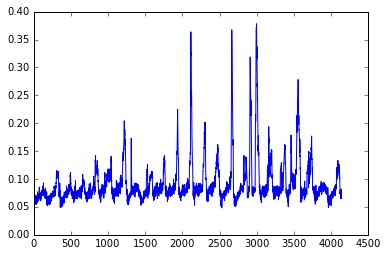

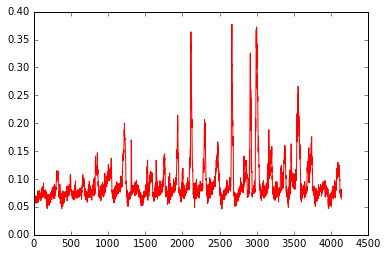

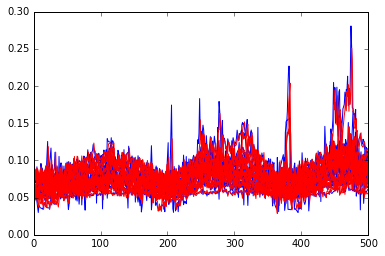

In [33]:
y = np.array(actual_output1)
pred = np.array(network_output1)


sum_mape = 0
for i in range(input_dim):
    mse1 = mean_squared_error(y[:,i],pred[:,i])
    mae1 = mean_absolute_error(y[:,i],pred[:,i])
    mape1 = mean_absolute_percentage_error(y[:,i],pred[:,i])
    print("  Mean Squared Error for Road", road_links[i],": ", mse1)
    print("  Mean Absolute Error for Road", road_links[i],": ",  mae1)
    print("  Mean Absolute Percentage Error for Road", road_links[i],": ",  mape1)
    sum_mape += mape1

mse_train = mean_squared_error(actual_output1, network_output1)
mae_train = mean_absolute_error(actual_output1, network_output1)
print("Average Mean Squared Error: ", mse_train)
print("Average Mean Absolute Error: ", mae_train)
print("Test Average Mean Percentage Absolute Error: ", sum_mape/input_dim)

plt.plot(range(len(actual_output1)), y[:,0], 'b-')
plt.show()
plt.plot(range(len(actual_output1)), pred[:,0], 'r-')
plt.show()

plt.plot(range(500), actual_output1[:500], 'b-', range(500), network_output1[:500], 'r-')
plt.show()

  Test Mean Squared Error for Road 2334 :  7.90372051188e-05
  Test Mean Absolute Error for Road 2334 :  0.00646442872229
  Test Mean Percentage Absolute Error for Road 2334 :  6.40007179914
  Test Mean Squared Error for Road 2240 :  9.23850381833e-05
  Test Mean Absolute Error for Road 2240 :  0.00718713675912
  Test Mean Percentage Absolute Error for Road 2240 :  6.00708496934
  Test Mean Squared Error for Road 2237 :  0.000177390346556
  Test Mean Absolute Error for Road 2237 :  0.0090758200589
  Test Mean Percentage Absolute Error for Road 2237 :  7.10822110676
  Test Mean Squared Error for Road 2236 :  3.90350401229e-05
  Test Mean Absolute Error for Road 2236 :  0.00423917284494
  Test Mean Percentage Absolute Error for Road 2236 :  4.6442611577
  Test Mean Squared Error for Road 2185 :  7.57762721377e-05
  Test Mean Absolute Error for Road 2185 :  0.00662819550684
  Test Mean Percentage Absolute Error for Road 2185 :  6.54937667368
  Test Mean Squared Error for Road 2184 :  8.61

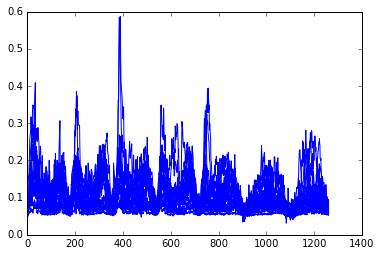

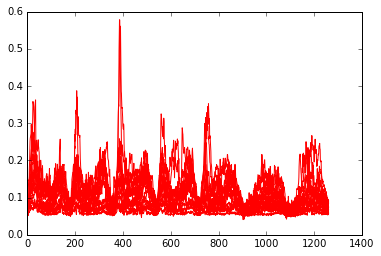

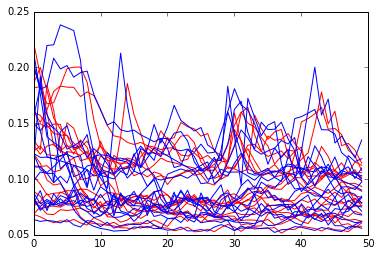

In [34]:
test_actual_output = []
test_network_output = []

for j in range(len(testX)):
    feed_dict = {
            state: numpy_state,
            input_layer: np.reshape(testX[j],(1,input_dim*dimensions_per_record)),
            correct_output: np.reshape(testY[j],(1,input_dim)),
            keep_p: 1.0
            }
    network_output, numpy_state = sess.run([final_output,final_state],
                                 feed_dict = feed_dict)
 
    test_actual_output.append(testY[j])
    test_network_output.append(network_output[0])
    
y = np.array(test_actual_output)
pred = np.array(test_network_output)



sum_mape = 0
for i in range(input_dim):
    mse1 = mean_squared_error(y[:,i],pred[:,i])
    mae1 = mean_absolute_error(y[:,i],pred[:,i])
    mape_test = mean_absolute_percentage_error(y[:,i],pred[:,i])
    print("  Test Mean Squared Error for Road", road_links[i],": ", mse1)
    print("  Test Mean Absolute Error for Road", road_links[i],": ",  mae1)
    print("  Test Mean Percentage Absolute Error for Road", road_links[i],": ",  mape_test)
    sum_mape += mape_test

mse_test = mean_squared_error(test_actual_output,test_network_output)
mae_test = mean_absolute_error(test_actual_output,test_network_output)
# mape_test = mean_absolute_percentage_error(test_actual_output,test_network_output)
print("Test Average Mean Squared Error: ", mse_test)
print("Test Average Mean Absolute Error: ", mae_test)
print("Test Average Mean Percentage Absolute Error: ", sum_mape/input_dim)

plt.plot( range(len(test_network_output)), test_actual_output, 'b-')
plt.show()

plt.plot(range(len(test_network_output)), test_network_output, 'r-')
plt.show()
# print(test_network_output[500][13])
plt.plot(range(50), test_network_output[50:100], 'r-', range(50), test_actual_output[50:100], 'b-')
plt.show()

In [35]:
output_dict = {}

buf = np.array(test_network_output)

print(buf.shape)
print (buf[:,0])
for i in range(len(road_links)):
    output_dict[road_links[i]] = buf[:,i]    #[s for s in buf[][]]

df3 = pd.DataFrame(output_dict)
# print(df3.columns)
df3.to_csv("pred_output_2_3_T.csv", index=False)



output_dict = {}

buf = np.array(testY)

print(buf.shape)
print (buf[:,0])
for i in range(len(road_links)):
    output_dict[road_links[i]] = buf[:,i]    #[s for s in buf[][]]

df3 = pd.DataFrame(output_dict)
# print(df3.columns)
df3.to_csv("y_output_2_3_T.csv", index=False)

(1261, 17)
[ 0.07480318  0.06972586  0.06448624 ...,  0.07249608  0.06816434
  0.07600903]
(1261, 17)
[ 0.06682789  0.06144249  0.0587498  ...,  0.06854143  0.07784348
  0.07429401]
